In [13]:
import tensorflow as tf
print("tensorflow version is", tf.__version__)
print("keras version is", tf.keras.__version__)

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.initializers import RandomNormal
import os
import matplotlib.pyplot as plt
import numpy as np

plt.ioff()  # not to show images inline
os.makedirs("out2", exist_ok=True)

tensorflow version is 2.1.0
keras version is 2.2.4-tf


In [14]:
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
print("data shape:", x_tr.shape, y_tr.shape, x_te.shape, y_te.shape)
print("image data range:", np.min(x_tr), np.max(x_tr))

data shape: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
image data range: 0 255


* sample training images *


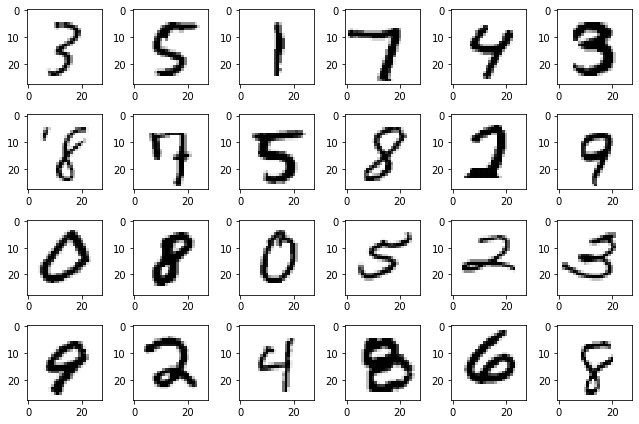

In [15]:
def plot_images(x, figsize=(9, 6), nrow=4, ncol=6):
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
    k = 0
    for i in range(nrow):
        for j in range(ncol):
            ax = axes[i][j]
            ax.imshow(x[k], cmap="gray_r")
            k += 1
    fig.tight_layout()
    return fig
print("* sample training images *")
ix = np.random.choice(len(x_tr), size=32, replace=False)
plot_images(x_tr[ix])

In [16]:
class RealDataset:
    def __init__(self, data, normalizer=None):
        self.data = np.expand_dims(data.astype("float32"), axis=-1)  # add channels dimension
        self.normalizer = normalizer
        self.index = 0  # current index
        self.iter_count = 0  # number of completed iteration
        self.randomize()

    def randomize(self):
        n = len(self.data)
        ix = np.random.permutation(n)
        self.data = self.data[ix]
    
    def get(self, size):
        out = self._get(size)
        if self.normalizer is None:
            return out
        else:
            return self.normalizer(out)

    def _get(self, size):
        n = len(self.data)
        i1 = self.index
        i2 = min(n, self.index + size)
        if i2 >= n:
            self.iter_count += 1
            self.randomize()
        out = self.data[i1:i2]
        self.index = (i2 % n)
        if len(out) == size:
            return out
        else:
            size_remain = size - len(out)
            out2 = self.get(size_remain)
            out = np.vstack((out, out2))
            return out


class Normalizer:
    def __init__(self, low=-1.0, high=1.0):
        self.low = low
        self.high = high
    
    def __call__(self, x):
        return x * (self.high - self.low) / 255.0 + self.low

(12, 28, 28) -1.0 1.0


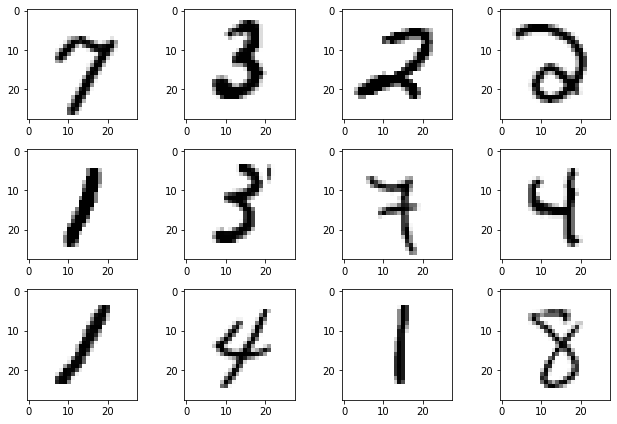

In [17]:
real_data = RealDataset(x_tr, normalizer=Normalizer())
test = real_data.get(12).squeeze()
print(test.shape, np.min(test), np.max(test))
plot_images(test, nrow=3, ncol=4)

In [18]:
def make_discriminator(filters=(64,64), kernel=(3,3), batch_norm=False,
                       input_shape=(28,28,1)):
    initializer = RandomNormal(0.0, 0.02)
    x = Input(input_shape)    
    y = x
    for f in filters:
        y = Conv2D(f, kernel, strides=(2,2), padding="same", kernel_initializer=initializer)(y)
        if batch_norm:
            y = BatchNormalization()(y)
        y = LeakyReLU(0.2)(y)
        y = Dropout(0.4)(y)
    y = Flatten()(y)
    y = Dense(1, activation="sigmoid", kernel_initializer=initializer)(y)
    model = Model(inputs=x, outputs=y)
    return model

discriminator = make_discriminator()
discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 64)          0   

In [19]:
def make_generator(input_size=100, filters=(128,128), init_filter=128,
                   init_shape=(7, 7), batch_norm=False):
    initializer = RandomNormal(0.0, 0.02)
    x = Input((input_size,))
    y = x
    n = init_filter * init_shape[0] * init_shape[1]
    y = Dense(n, kernel_initializer=initializer)(y)
    if batch_norm:
        y = BatchNormalization()(y)
    y = LeakyReLU(0.2)(y)
    y = Reshape(init_shape + (init_filter,))(y)
    for f in filters:
        y = Conv2DTranspose(f, (4,4), strides=(2,2), padding="same", kernel_initializer=initializer)(y)
        if batch_norm:
            y = BatchNormalization()(y)
        y = LeakyReLU(0.2)(y)
    y = Conv2D(1, (7,7), activation="tanh", padding="same", kernel_initializer=initializer)(y)
    model = Model(inputs=x, outputs=y)
    return model

generator = make_generator()
generator.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 128)       2622

(6, 28, 28) -0.07617541 0.076270245


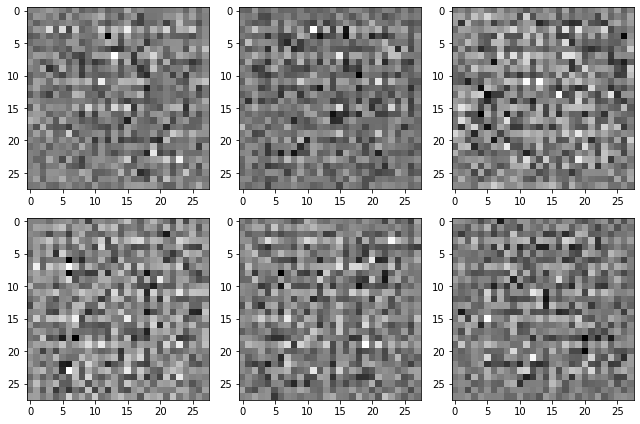

In [20]:
def generate_latent(generator, n_sample=128):
    latent_size = generator.input_shape[1]
    latent = np.random.randn(n_sample, latent_size)
    return latent

def generate_fake_data(generator, n_sample=128):
    latent = generate_latent(generator, n_sample)
    out = generator.predict(latent)
    return out

fake = generate_fake_data(generator, 6).squeeze()  # remove the channels dimension
print(fake.shape, np.min(fake), np.max(fake))
plot_images(fake, nrow=2, ncol=3)

In [21]:
class GAN:
    def __init__(self, generator, discriminator, data, test_data,
                 name="mnist", **kwargs):
        self.generator = generator
        self.discriminator = discriminator
        self.data = data
        self.test_data = test_data
        self.name = name
        self.setup(**kwargs)
        
    def setup(self,
              lr_d=0.0002, beta1_d=0.5, beta2_d=0.999,
              lr_g=0.0002, beta1_g=0.5, beta2_g=0.999):
        self.discriminator.trainable = True
        opt = Adam(learning_rate=lr_d, beta_1=beta1_d, beta_2=beta2_d)
        self.discriminator.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
        
        self.discriminator.trainable = False
        x = Input(self.generator.input_shape[1:])
        y = self.generator(x)
        y = self.discriminator(y)
        gan = Model(inputs=x, outputs=y)
        opt = Adam(learning_rate=lr_g, beta_1=beta1_g, beta_2=beta2_g)
        gan.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
        self.gan = gan
    
    def train_step(self, batchsize=512, update_discriminator_separately=True):
        # train discriminator
        halfbatch = int(batchsize/2)
        x_real = self.data.get(halfbatch)
        y_real = np.ones((halfbatch, 1))
        x_fake = generate_fake_data(self.generator, halfbatch)
        y_fake = np.zeros((halfbatch, 1))
        if update_discriminator_separately:
            res_d_real = self.discriminator.train_on_batch(x_real, y_real)        
            res_d_fake = self.discriminator.train_on_batch(x_fake, y_fake)
            res_d = tuple((a+b)/2 for a, b in zip(res_d_real, res_d_fake))
        else:
            res_d = self.discriminator.train_on_batch(
                np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
            )
        
        # train generator
        x_gan = generate_latent(self.generator, batchsize)
        y_gan = np.ones((batchsize, 1))
        res_g = self.gan.train_on_batch(x_gan, y_gan)
        
        return res_d, res_g
    
    def evaluate(self, iteration, batchsize=256):
        x_real = self.test_data.get(batchsize)
        y_real = np.ones((batchsize, 1))
        loss_real, acc_real = self.discriminator.evaluate(x_real, y_real, verbose=False)
        x_fake = generate_fake_data(self.generator, batchsize)
        y_fake = np.zeros((batchsize, 1))
        loss_fake, acc_fake = self.discriminator.evaluate(x_fake, y_fake, verbose=False)
        print("\nIter %d: loss=(%.3f, %.3f), acc=(%.3f, %.3f)" % (
              iteration+1, loss_real, loss_fake, acc_real, acc_fake))
        
    def generate_sample(self, nrow=4, ncol=6, figsize=(10, 6)):
        fake = generate_fake_data(self.generator, nrow*ncol).squeeze()
        images = plot_images(fake, figsize=figsize, nrow=nrow, ncol=ncol)
        return images
    
    def save_model(self, index):
        path = "out2/%s-generator_%07d.h5" % (self.name, index)
        self.generator.save(path)
        path = "out2/%s-discriminator_%07d.h5" % (self.name, index)
        self.discriminator.save(path)
        
    def train(self, n_iter=10000, batchsize=256, update_discriminator_separately=True,
              eval_by=1000, batchsize_eval=128, nrow=4, ncol=6, figsize=(10, 6)):
        # image from the initial generator
        fig = self.generate_sample(nrow=nrow, ncol=ncol, figsize=figsize)
        imagepath = "out2/%s%07d.png" % (self.name, 0)
        fig.savefig(imagepath)
        plt.close(fig)
        history = {"loss_d":[], "loss_g":[], "acc_d":[], "acc_g":[]}
        for i in range(n_iter):
            (loss_d, acc_d), (loss_g, acc_g) = self.train_step(
                batchsize, update_discriminator_separately=update_discriminator_separately)
            print("\r#%6d: loss=(%.3f, %.3f), acc=(%.3f, %.3f)" % (i+1, loss_d, loss_g, acc_d, acc_g), end="")
            history["loss_d"].append(loss_d)
            history["loss_g"].append(loss_g)
            history["acc_d"].append(acc_d)
            history["acc_g"].append(acc_g)
            if (i+1) % eval_by == 0:
                self.evaluate(i, batchsize_eval)
                fig = self.generate_sample(nrow=nrow, ncol=ncol, figsize=figsize)
                imagepath = "out2/%s_%07d.png" % (self.name, i+1)
                fig.savefig(imagepath)
                plt.close(fig)
                self.save_model(i+1)
        return history

# test
gan = GAN(generator, discriminator, real_data, real_data, name="test")
history = gan.train(n_iter=10, batchsize=64, eval_by=2)

#     2: loss=(0.679, 0.692), acc=(0.500, 1.000)
Iter 2: loss=(0.651, 0.696), acc=(1.000, 0.000)
#     4: loss=(0.669, 0.686), acc=(0.500, 1.000)
Iter 4: loss=(0.621, 0.704), acc=(1.000, 0.000)
#     6: loss=(0.660, 0.669), acc=(0.500, 1.000)
Iter 6: loss=(0.585, 0.729), acc=(1.000, 0.000)
#     8: loss=(0.663, 0.633), acc=(0.500, 1.000)
Iter 8: loss=(0.551, 0.780), acc=(1.000, 0.000)
#    10: loss=(0.681, 0.596), acc=(0.500, 1.000)
Iter 10: loss=(0.540, 0.825), acc=(1.000, 0.000)


(24, 28, 28) -0.9729952 -0.0803772


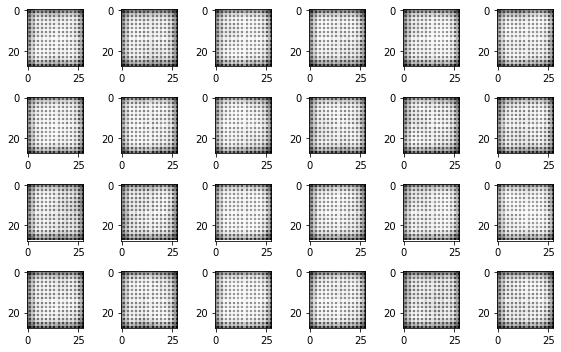

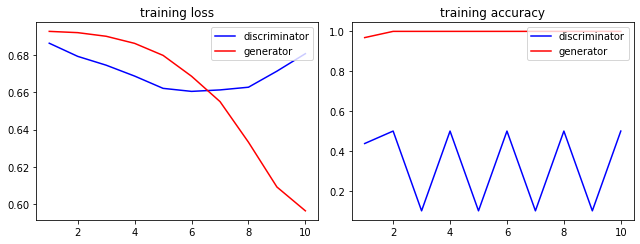

In [22]:
def post_estimation_summary(gan, history):
    fake = generate_fake_data(gan.generator, 24).squeeze()  # remove the channels dimension
    print(fake.shape, np.min(fake), np.max(fake))
    fig = plot_images(fake, nrow=4, ncol=6, figsize=(8, 5))
    display(fig)
    plt.close(fig)
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 3.5))
    n = len(history["loss_d"])
    ax[0].plot(range(1, n+1), history["loss_d"], color="blue", label="discriminator")
    ax[0].plot(range(1, n+1), history["loss_g"], color="red", label="generator")
    ax[0].set_title("training loss")
    ax[0].legend(loc="upper right")
    ax[1].plot(range(1, n+1), history["acc_d"], color="blue", label="discriminator")
    ax[1].plot(range(1, n+1), history["acc_g"], color="red", label="generator")
    ax[1].set_title("training accuracy")
    ax[1].legend(loc="upper right")
    fig.tight_layout()
    display(fig)
    plt.close(fig)

# test
post_estimation_summary(gan, history)

#  1000: loss=(0.702, 0.705), acc=(0.504, 0.434)
Iter 1000: loss=(0.694, 0.689), acc=(0.531, 0.562)
#  2000: loss=(0.695, 0.679), acc=(0.500, 0.609)
Iter 2000: loss=(0.668, 0.735), acc=(0.672, 0.109)
#  3000: loss=(0.687, 0.718), acc=(0.574, 0.320)
Iter 3000: loss=(0.692, 0.687), acc=(0.586, 0.586)
#  4000: loss=(0.686, 0.712), acc=(0.578, 0.336)
Iter 4000: loss=(0.672, 0.691), acc=(0.883, 0.594)
#  5000: loss=(0.688, 0.714), acc=(0.566, 0.340)
Iter 5000: loss=(0.683, 0.687), acc=(0.742, 0.703)
#  6000: loss=(0.694, 0.696), acc=(0.504, 0.480)
Iter 6000: loss=(0.677, 0.703), acc=(0.836, 0.289)
#  7000: loss=(0.692, 0.700), acc=(0.551, 0.461)
Iter 7000: loss=(0.683, 0.709), acc=(0.680, 0.289)
#  8000: loss=(0.703, 0.689), acc=(0.449, 0.543)
Iter 8000: loss=(0.683, 0.710), acc=(0.664, 0.188)
#  9000: loss=(0.706, 0.693), acc=(0.457, 0.508)
Iter 9000: loss=(0.694, 0.712), acc=(0.508, 0.180)
# 10000: loss=(0.695, 0.702), acc=(0.492, 0.457)
Iter 10000: loss=(0.677, 0.698), acc=(0.922, 0.367)

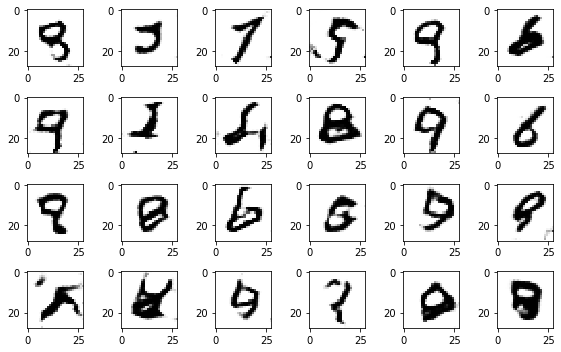

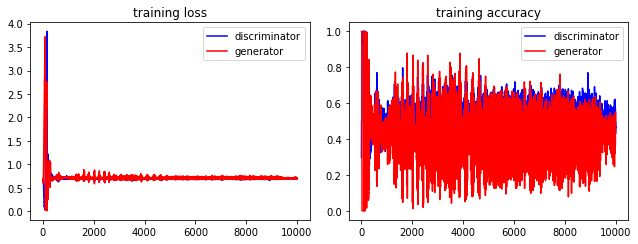

In [11]:
data = RealDataset(x_tr, normalizer=Normalizer())
test_data = RealDataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator()
generator = make_generator()
gan = GAN(generator, discriminator, data, test_data, name="mnist")
history = gan.train(n_iter=10000)

post_estimation_summary(gan, history)

#  1000: loss=(0.000, 0.041), acc=(1.000, 1.000)
Iter 1000: loss=(0.000, 4.018), acc=(1.000, 0.000)
#  2000: loss=(0.000, 0.314), acc=(1.000, 0.969)
Iter 2000: loss=(0.000, 1.581), acc=(1.000, 0.000)
#  3000: loss=(0.000, 0.020), acc=(1.000, 1.000)
Iter 3000: loss=(0.000, 4.321), acc=(1.000, 0.000)
#  4000: loss=(0.000, 0.001), acc=(1.000, 1.000)
Iter 4000: loss=(0.000, 7.615), acc=(1.000, 0.000)
#  5000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 5000: loss=(0.000, 7.876), acc=(1.000, 0.000)
#  6000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 6000: loss=(0.000, 8.646), acc=(1.000, 0.000)
#  7000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 7000: loss=(0.000, 8.998), acc=(1.000, 0.000)
#  8000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 8000: loss=(0.000, 10.763), acc=(1.000, 0.000)
#  9000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 9000: loss=(0.000, 13.427), acc=(1.000, 0.000)
# 10000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 10000: loss=(0.000, 12.820), acc=(1.000, 0.0

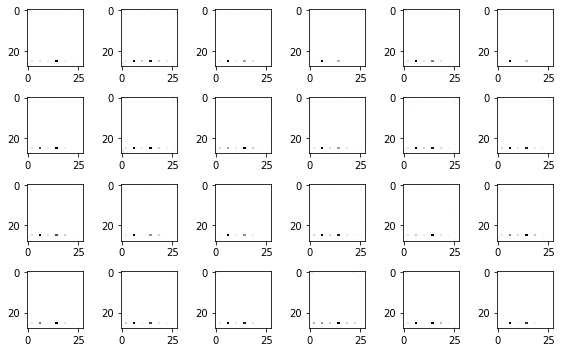

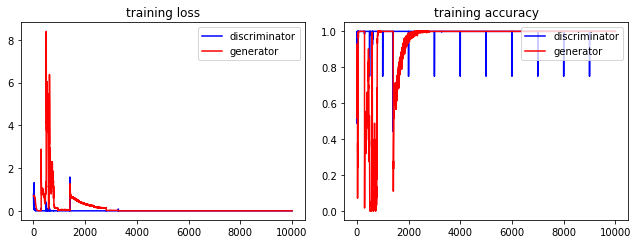

In [12]:
data = RealDataset(x_tr, normalizer=Normalizer())
test_data = RealDataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator(batch_norm=True)
generator = make_generator(batch_norm=True)
gan = GAN(generator, discriminator, data, test_data, name="mnist-batchnorm")
history = gan.train(n_iter=10000)

post_estimation_summary(gan, history)

#  1000: loss=(0.725, 0.709), acc=(0.371, 0.445)
Iter 1000: loss=(0.745, 0.681), acc=(0.141, 0.664)
#  2000: loss=(0.694, 0.706), acc=(0.539, 0.320)
Iter 2000: loss=(0.695, 0.677), acc=(0.594, 0.953)
#  3000: loss=(0.697, 0.695), acc=(0.426, 0.480)
Iter 3000: loss=(0.677, 0.706), acc=(0.891, 0.164)
#  4000: loss=(0.699, 0.699), acc=(0.430, 0.410)
Iter 4000: loss=(0.684, 0.729), acc=(0.703, 0.000)
#  5000: loss=(0.693, 0.697), acc=(0.469, 0.398)
Iter 5000: loss=(0.680, 0.701), acc=(0.898, 0.250)
#  6000: loss=(0.694, 0.699), acc=(0.496, 0.391)
Iter 6000: loss=(0.680, 0.699), acc=(0.898, 0.234)
#  7000: loss=(0.694, 0.697), acc=(0.438, 0.465)
Iter 7000: loss=(0.680, 0.701), acc=(0.922, 0.141)
#  8000: loss=(0.693, 0.694), acc=(0.496, 0.480)
Iter 8000: loss=(0.672, 0.708), acc=(0.898, 0.164)
#  9000: loss=(0.692, 0.696), acc=(0.500, 0.457)
Iter 9000: loss=(0.675, 0.703), acc=(0.969, 0.125)
# 10000: loss=(0.693, 0.696), acc=(0.512, 0.438)
Iter 10000: loss=(0.675, 0.705), acc=(0.992, 0.078)

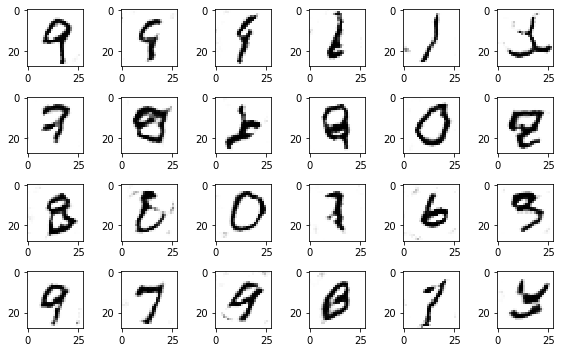

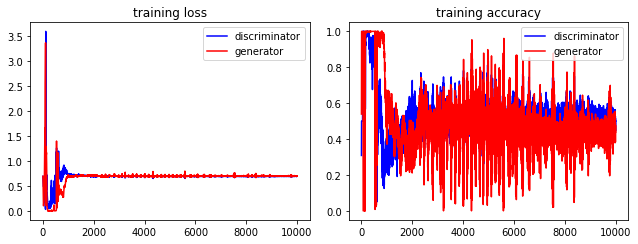

In [13]:
data = RealDataset(x_tr, normalizer=Normalizer())
test_data = RealDataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator(batch_norm=False)
generator = make_generator(batch_norm=True)
gan = GAN(generator, discriminator, data, test_data,
          name="mnist-g-batchnorm")
history = gan.train(n_iter=10000)

post_estimation_summary(gan, history)

#  1000: loss=(0.000, 0.017), acc=(1.000, 1.000)
Iter 1000: loss=(0.000, 4.376), acc=(1.000, 0.000)
#  2000: loss=(0.000, 0.067), acc=(1.000, 1.000)
Iter 2000: loss=(0.000, 2.902), acc=(1.000, 0.000)
#  3000: loss=(0.000, 0.012), acc=(1.000, 1.000)
Iter 3000: loss=(0.000, 4.536), acc=(1.000, 0.000)
#  4000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 4000: loss=(0.000, 9.538), acc=(1.000, 0.000)
#  5000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 5000: loss=(0.000, 9.436), acc=(1.000, 0.000)
#  6000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 6000: loss=(0.000, 10.975), acc=(1.000, 0.000)
#  7000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 7000: loss=(0.000, 10.867), acc=(1.000, 0.000)
#  8000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 8000: loss=(0.000, 14.225), acc=(1.000, 0.000)
#  9000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 9000: loss=(0.000, 18.304), acc=(1.000, 0.000)
# 10000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 10000: loss=(0.000, 17.621), acc=(1.000, 0

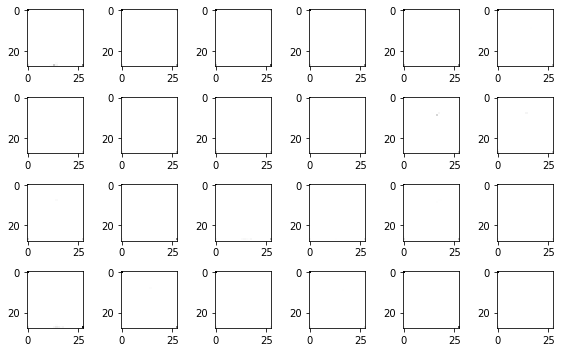

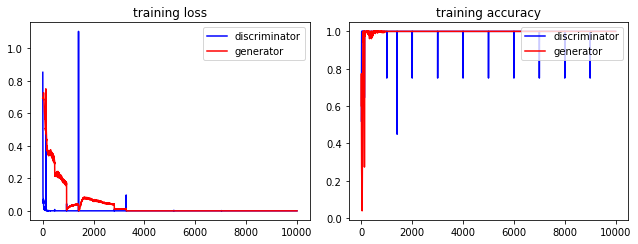

In [14]:
data = RealDataset(x_tr, normalizer=Normalizer())
test_data = RealDataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator(batch_norm=True)
generator = make_generator(batch_norm=False)
gan = GAN(generator, discriminator, data, test_data,
          name="mnist-d-batchnorm")
history = gan.train(n_iter=10000)

post_estimation_summary(gan, history)

#  1000: loss=(0.653, 0.038), acc=(0.636, 0.999)
Iter 1000: loss=(0.021, 3.805), acc=(1.000, 0.000)
#  2000: loss=(0.710, 0.071), acc=(0.534, 1.000)
Iter 2000: loss=(0.062, 2.896), acc=(1.000, 0.000)
#  3000: loss=(0.661, 1.948), acc=(0.598, 0.003)
Iter 3000: loss=(1.762, 0.151), acc=(0.000, 1.000)
#  4000: loss=(0.617, 1.077), acc=(0.672, 0.199)
Iter 4000: loss=(0.965, 0.426), acc=(0.172, 0.945)
#  5000: loss=(0.702, 0.987), acc=(0.574, 0.163)
Iter 5000: loss=(0.927, 0.474), acc=(0.055, 1.000)
#  6000: loss=(0.644, 0.645), acc=(0.612, 0.607)
Iter 6000: loss=(0.552, 0.797), acc=(0.922, 0.195)
#  7000: loss=(0.431, 0.962), acc=(0.816, 0.377)
Iter 7000: loss=(0.743, 0.625), acc=(0.422, 0.711)
#  8000: loss=(0.518, 0.084), acc=(0.747, 0.996))
Iter 8000: loss=(0.051, 2.743), acc=(1.000, 0.000)
#  9000: loss=(0.610, 1.499), acc=(0.663, 0.090)
Iter 9000: loss=(1.127, 0.290), acc=(0.172, 1.000)
# 10000: loss=(0.643, 0.948), acc=(0.611, 0.261)
Iter 10000: loss=(0.621, 0.612), acc=(0.758, 0.820

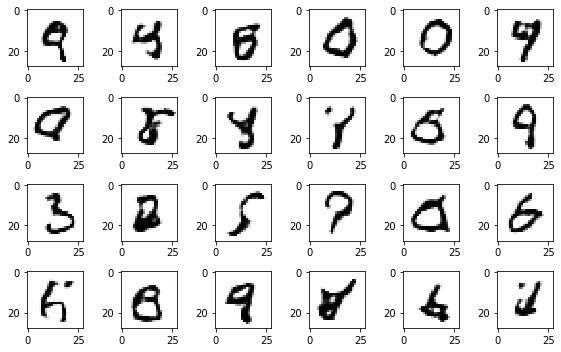

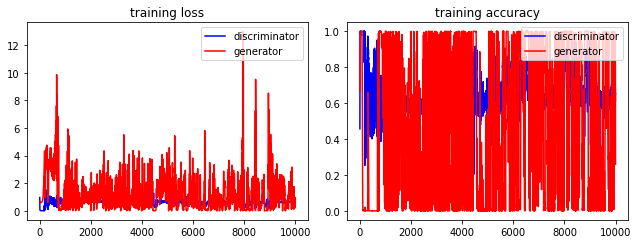

In [15]:
data = RealDataset(x_tr, normalizer=Normalizer())
test_data = RealDataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator(batch_norm=True)
generator = make_generator(batch_norm=True)
gan = GAN(generator, discriminator, data, test_data,
          name="mnist-batchnorm-stacked-update-large-batch")
history = gan.train(n_iter=10000, batchsize=1024, update_discriminator_separately=False)

post_estimation_summary(gan, history)

#  1000: loss=(0.000, 0.017), acc=(1.000, 1.000)
Iter 1000: loss=(0.000, 4.455), acc=(1.000, 0.000)
#  2000: loss=(0.000, 0.003), acc=(1.000, 1.000)
Iter 2000: loss=(0.000, 5.996), acc=(1.000, 0.000)
#  3000: loss=(0.000, 0.001), acc=(1.000, 1.000)
Iter 3000: loss=(0.000, 6.810), acc=(1.000, 0.000)
#  4000: loss=(0.000, 0.001), acc=(1.000, 1.000)
Iter 4000: loss=(0.000, 6.917), acc=(1.000, 0.000)
#  5000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 5000: loss=(0.000, 8.020), acc=(1.000, 0.000)
#  6000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 6000: loss=(0.000, 9.728), acc=(1.000, 0.000)
#  7000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 7000: loss=(0.000, 10.846), acc=(1.000, 0.000)
#  8000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 8000: loss=(0.000, 10.917), acc=(1.000, 0.000)
#  9000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 9000: loss=(0.000, 12.080), acc=(1.000, 0.000)
# 10000: loss=(0.000, 0.000), acc=(1.000, 1.000)
Iter 10000: loss=(0.000, 12.783), acc=(1.000, 0.

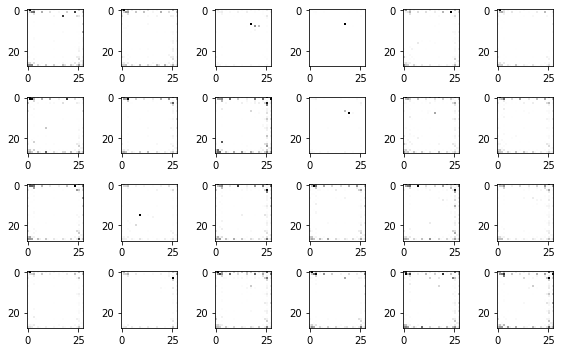

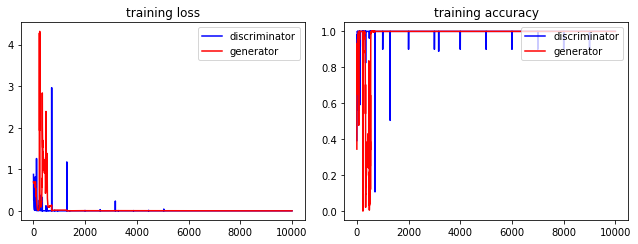

In [16]:
data = RealDataset(x_tr, normalizer=Normalizer())
test_data = RealDataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator(batch_norm=True)
generator = make_generator(batch_norm=True)
gan = GAN(generator, discriminator, data, test_data,
          name="mnist-batchnorm-large-batch")
history = gan.train(n_iter=10000, batchsize=1024)

post_estimation_summary(gan, history)